아래의 데이터셋은 bAbI 데이터셋을 저자가 한국어로 변환한 한국어 버전의 bAbI 데이터셋입니다.

# 데이터 다운로드(로컬 유저용)

[e-28-korean.zip](https://aiffelstaticprd.blob.core.windows.net/media/documents/e-28-korean.zip)

압축을 해제해서 사용해주세요.

##### [데이터셋 소개]

데이터셋의 형태는 아래와 같이 영어 데이터셋과 동일합니다.

``` python
1 은경이는 복도로 가버렸습니다.
2 필웅이는 화장실로 뛰어갔습니다.
3 은경이는 어디야?     복도  1
4 수종이는 화장실로 복귀했습니다.
5 은경이는 침실로 갔습니다.
6 필웅이는 어디야?     화장실 2
7 은경이는 복도로 이동했습니다.
8 경임이는 부엌으로 뛰어갔습니다.
9 경임이는 어디야?     부엌  8
10 경임이는 복도로 가버렸습니다.
11 은경이는 정원으로 이동했습니다.
12 경임이는 어디야?     복도  10
13 경임이는 화장실로 복귀했습니다.
14 경임이는 부엌으로 갔습니다.
15 경임이는 어디야?     부엌  14
```

이번 프로젝트에서는 위 한국어 버전의 데이터셋에 대해서 동작하는 QA 모델을 만들어보겠습니다.

>___주의❗___  
_기존 케라스 공식 문서의 babi_rnn, babi_memn 구현은 파이썬 3.6을 기준으로 하고 있으며, 파이썬 3.7에서는 정상동작 하지 않을 수 있습니다. 실습 시 참고하세요!_

## 라이브러리 임포트

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

## 데이터 로드

In [2]:
home_dir = os.getenv('HOME')+'/aiffel/babi_memory_net'
DATA_DIR = home_dir + '/e-28-korean'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test_kor.txt")

## 데이터 확인

In [4]:
# 훈련 데이터 20 문장 출력
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


---

# Step 1. 토크나이저 변경하기 (매우 중요!!!)

영어권 언어는 띄어쓰기만해도 단어들이 잘 분리되지만, 한국어는 그렇지 않다고 앞에서 몇 차례 언급했었죠? 한국어 데이터를 사용하여 모델을 구현하는 것만큼 이번에는 형태소 분석기를 사용해서 단어 토큰화를 해보겠습니다.

그런데 형태소 분석기를 사용할 때, 이런 상황에 봉착한다면 어떻게 해야할까요?

``` python
형태소 분석 입력 : '은경이는 사무실로 갔습니다.'
형태소 분석 결과 : ['은', '경이', '는', '사무실', '로', '갔습니다', '.']
```

사실 위 문장에서 '은경이'는 사람 이름이므로 제대로 된 결과를 얻기 위해서는 '은', '경이'와 같이 글자가 분리되는 것이 아니라 '은경이' 또는 최소한 '은경'이라는 단어 토큰을 얻어야만 합니다.

이런 경우에는 형태소 분석기에 사용자 사전을 추가해줄 수 있습니다.

'은경이'는 하나의 단어이기 때문에 분리하지말라고 형태소 분석기에 알려주는 것이죠.

사용자 사전을 추가하는 방법은 형태소 분석기마다 다소 다른데, 생각보다 복잡한 경우도 많습니다. 이번 실습에서는 Customized Konlpy라는 사용자 사전 추가가 매우 쉬운 패키지를 사용합니다.

##### Customized Konlpy 설치 방법

###### 로컬유저용

설치 방법과 사용 방법에 대한 자세한 설명은 아래의 링크를 참고하세요!

- [Customized Konlpy 사용하기](https://inspiringpeople.github.io/data%20analysis/ckonlpy/)

가령, 트위터라는 형태소 분석기를 사용한다고 하였을 때, '은경이'라는 단어를 사용자 사전에 추가하고 나서 문장을 형태소 분석하려면 어떻게 해야 할까요?

``` python
# 예시 코드
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('은경이', 'Noun')
twitter.morphs('은경이는 사무실로 갔습니다.')
```

## 데이터 전처리 (1) 기본 전처리

- 데이터를 스토리, 질문, 답변으로 각각 분리해서 저장
- supporting fact(실제 정답이 몇번째 문장에 있었는지를 알려주는 인덱스 힌트정보)는 저장하지 않음

In [5]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [6]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [7]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [8]:
# 각각의 샘플 개수 출력
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


In [9]:
# 임의로 3,879번째 스토리 출력
train_stories[3878]

['수종이는 화장실로 뛰어갔습니다.',
 '경임이는 사무실로 갔습니다.',
 '은경이는 부엌으로 이동했습니다.',
 '경임이는 화장실로 갔습니다.',
 '수종이는 복도로 갔습니다.',
 '필웅이는 부엌으로 가버렸습니다.',
 '수종이는 부엌으로 이동했습니다.',
 '수종이는 화장실로 가버렸습니다.']

In [10]:
# 상위 5개의 질문 출력
train_questions[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

In [12]:
#상위 5개의 답변 출력
train_answers[:5]

['화장실', '복도', '복도', '사무실', '화장실']

## Tokenize

In [13]:
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('필웅이', 'Noun')
twitter.add_dictionary('수종이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')

/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [14]:
def tokenize(sent):
    return twitter.morphs(sent)

In [15]:
# 전처리 함수
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [16]:
# 전처리 함수를 사용하여 단어장과 가장 긴 샘플의 길이를 리턴
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [17]:
# 단어장 출력
print(word2idx)

{'는': 1, '.': 2, '로': 3, '했습니다': 4, '으로': 5, '경임이': 6, '은경이': 7, '수종이': 8, '필웅이': 9, '이동': 10, '가버렸습니다': 11, '뛰어갔습니다': 12, '복귀': 13, '화장실': 14, '정원': 15, '복도': 16, '갔습니다': 17, '사무실': 18, '부엌': 19, '침실': 20, '어디': 21, '야': 22, '?': 23}


In [18]:
# 실제 변수로 사용할 단어장의 크기는 패딩을 고려하여 +1
vocab_size = len(word2idx) + 1

In [19]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 70
질문의 최대 길이 : 5


---

# Step 2. 형태소 분석 후 불용어 처리하기

형태소 분석기로 문자를 분석해보면 '는', '으로' 등 분석에 크게 도움이 되지 않을 것 같은 토큰들이 나올 거에요. 처음에는 이 토큰들도 그대로 사용해서 모델을 구현해보고, 두 번째 구현에서는 이 토큰들을 전처리 과정에서 불용어 처리하여 제외해 봅시다.

## 데이터 전처리 (2) 패딩, 정수 인코딩, 벡터화

1. 현재 각 데이터는 전부 텍스트 데이터입니다. 이를 단어와 맵핑되는 정수로 인코딩해줍니다. 이 과정은 앞서 만들어놓은 word2idx를 활용합니다.
2. 스토리와 질문 데이터에 대해서 각각의 최대 길이로 패딩(padding)합니다. 이 과정은 앞서 계산해놓은 story_max_len과 question_max_len을 사용합니다.
3. 레이블에 해당되는 정답 데이터를 원-핫 인코딩합니다.

In [20]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [21]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [22]:
# 반환된 결과의 크기(shape)를 확인
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 70) (10000, 5) (10000, 24) (1000, 70) (1000, 5) (1000, 24)


## 메모리 네트워크 구현

In [23]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [36]:
# 에포크 횟수
train_epochs = 150
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.20

In [37]:
# 입력을 담아두는 변수들을 정의
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 70), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


In [38]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [39]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [40]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 70, 50), dtype=tf.float32, name=None), name='sequential_3/dropout_4/Identity:0', description="created by layer 'sequential_3'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 70, 5), dtype=tf.float32, name=None), name='sequential_4/dropout_5/Identity:0', description="created by layer 'sequential_4'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 5, 50), dtype=tf.float32, name=None), name='sequential_5/dropout_6/Identity:0', description="created by layer 'sequential_5'")


In [41]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 70, 5), dtype=tf.float32, name=None), name='activation_2/truediv:0', description="created by layer 'activation_2'")


In [42]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 5, 70), dtype=tf.float32, name=None), name='permute_1/transpose:0', description="created by layer 'permute_1'")


In [43]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 5, 120), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")


---

# Step 3. 한국어에서의 모델 정확도 확인해보기

앞서 만든 메모리 네트워크는 영어권 데이터에서는 보편적으로 약 96% 이상의 높은 성능을 보입니다. 하이퍼파라미터를 잘 조정하면 이보다 더 높은 정확도가 나오기도 합니다. 그렇다면 메모리 네트워크가 한국어에서도 영어만큼 잘 동작할까요? 직접 확인해 봅시다.

## 모델 학습

In [44]:
# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/model_ko.h5'
model.save(model_path)

Epoch 1/150
313/313 [==============================] - 4s 6ms/step - loss: 2.0013 - acc: 0.1734 - val_loss: 1.7936 - val_acc: 0.1540
Epoch 2/150
313/313 [==============================] - 1s 4ms/step - loss: 1.7525 - acc: 0.2199 - val_loss: 1.6143 - val_acc: 0.3070
Epoch 3/150
313/313 [==============================] - 1s 4ms/step - loss: 1.5876 - acc: 0.3286 - val_loss: 1.5499 - val_acc: 0.3680
Epoch 4/150
313/313 [==============================] - 1s 4ms/step - loss: 1.4901 - acc: 0.3864 - val_loss: 1.4357 - val_acc: 0.4340
Epoch 5/150
313/313 [==============================] - 1s 4ms/step - loss: 1.4387 - acc: 0.4216 - val_loss: 1.4025 - val_acc: 0.4710
Epoch 6/150
313/313 [==============================] - 1s 3ms/step - loss: 1.3810 - acc: 0.4565 - val_loss: 1.3551 - val_acc: 0.4710
Epoch 7/150
313/313 [==============================] - 1s 3ms/step - loss: 1.3228 - acc: 0.4937 - val_loss: 1.3198 - val_acc: 0.4930
Epoch 8/150
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 3ms/step - loss: 0.0905 - acc: 0.9689 - val_loss: 0.4156 - val_acc: 0.8890
Epoch 63/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0950 - acc: 0.9690 - val_loss: 0.4111 - val_acc: 0.8890
Epoch 64/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0810 - acc: 0.9734 - val_loss: 0.3981 - val_acc: 0.8860
Epoch 65/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0706 - acc: 0.9760 - val_loss: 0.3975 - val_acc: 0.8950
Epoch 66/150
313/313 [==============================] - 1s 4ms/step - loss: 0.0711 - acc: 0.9778 - val_loss: 0.4026 - val_acc: 0.8990
Epoch 67/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0654 - acc: 0.9806 - val_loss: 0.3798 - val_acc: 0.9020
Epoch 68/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0669 - acc: 0.9771 - val_loss: 0.3643 - val_acc: 0.9000
Epoch 69/150
313/313 [==============================] - 1s 3ms/step - loss:

313/313 [==============================] - 1s 3ms/step - loss: 0.0206 - acc: 0.9942 - val_loss: 0.3498 - val_acc: 0.9330
Epoch 124/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0085 - acc: 0.9972 - val_loss: 0.3265 - val_acc: 0.9440
Epoch 125/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0135 - acc: 0.9962 - val_loss: 0.3296 - val_acc: 0.9420
Epoch 126/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0070 - acc: 0.9978 - val_loss: 0.3434 - val_acc: 0.9440
Epoch 127/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0083 - acc: 0.9980 - val_loss: 0.3785 - val_acc: 0.9410
Epoch 128/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0107 - acc: 0.9971 - val_loss: 0.3653 - val_acc: 0.9460
Epoch 129/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0063 - acc: 0.9983 - val_loss: 0.3645 - val_acc: 0.9390
Epoch 130/150
313/313 [==============================] - 1s 3ms/step 

In [45]:
# 테스트 정확도 출력
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.3963 - acc: 0.9440

 테스트 정확도: 0.9440


## 시각화

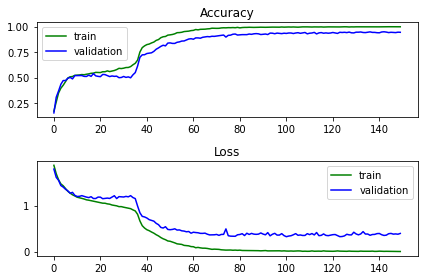

In [46]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [47]:
# 임의로 30개의 예측 결과 출력
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
은경이 는 어디 야 ?        : 복도       복도
필웅이 는 어디 야 ?        : 화장실      화장실
경임이 는 어디 야 ?        : 부엌       부엌
경임이 는 어디 야 ?        : 복도       복도
경임이 는 어디 야 ?        : 부엌       부엌
경임이 는 어디 야 ?        : 복도       복도
경임이 는 어디 야 ?        : 정원       정원
수종이 는 어디 야 ?        : 복도       복도
경임이 는 어디 야 ?        : 사무실      사무실
수종이 는 어디 야 ?        : 사무실      정원
필웅이 는 어디 야 ?        : 부엌       부엌
필웅이 는 어디 야 ?        : 정원       정원
수종이 는 어디 야 ?        : 사무실      사무실
필웅이 는 어디 야 ?        : 침실       침실
필웅이 는 어디 야 ?        : 침실       침실
은경이 는 어디 야 ?        : 부엌       부엌
은경이 는 어디 야 ?        : 정원       정원
은경이 는 어디 야 ?        : 부엌       부엌
수종이 는 어디 야 ?        : 사무실      사무실
은경이 는 어디 야 ?        : 부엌       복도
필웅이 는 어디 야 ?        : 복도       복도
은경이 는 어디 야 ?        : 사무실      사무실
은경이 는 어디 야 ?        : 사무실      사무실
경임이 는 어디 야 ?        : 복도       복도
수종이 는 어디 야 ?        : 침실       침실
경임이 는 어디 야 ?        : 침실       침실
필웅이 는 어디 야 ?        : 침실       침실
수종이

---

# 루브릭

__1. 한국어의 특성에 알맞게 전처리가 진행되었다.__  

- 한국어 특성에 따른 토큰화, 임베딩을 거쳐 데이터셋이 적절히 구성되었다.
- Customized Konlpy를 사용하여 사용자 사전 추가를 실행했다.

__2. 메모리 네트워크가 정상적으로 구현되어 학습이 안정적으로 진행되었다.__  

- validation loss가 안정적으로 수렴하는 것을 확인하고 이를 시각화하였다.

__3. 메모리 네트워크를 통해 한국어 bAbI 태스크의 높은 정확도를 달성하였다.__ 

- 추론 태스크의 테스트 정확도가 90% 이상 달성하였다. : 94% 달성
- 임의로 출력한 30개의 예측 결과 중 오답은 1개였다.

---

# 회고

- 이번 노드는 그대로 따라서 진행하되 한국어로만 변경하면 되서 비교적 쉬웠다.
- Customized Konlpy를 사용해 사전에 단어를 직접 추가하는 방법을 알 수 있었다.
- 그러나 생각보다 정확도 90%가 나오지 않아 하이퍼파라미터를 몇 가지 변경해 가면서 시도해 보았고 그 과정에서 시각화를 통해 결과가 어떻게 변하는지 파악할 수 있었다.